# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("GOOGLE/PALM")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
from vanna.google import GoogleGeminiChat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'gemini-2.5-flash-preview-05-20'  # 'gemini-1.5-pro'  
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, GoogleGeminiChat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        GoogleGeminiChat.__init__(self, config=config)
        

In [5]:
vn = MyVanna(config=CONFIG)

/home/papagame/anaconda3/envs/data-copilot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

In [7]:
def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [8]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [9]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [10]:
vn.run_sql_is_set

True

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
1,4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl,default,None,"CREATE TABLE sqlite_sequence(name,seq)",ddl
2,981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl,default,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
3,90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl,default,None,"CREATE TABLE ""customers""\r\n(\r\n CustomerI...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl,default,None,"CREATE TABLE ""genres""\r\n(\r\n GenreId INTE...",ddl
6,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
7,90be1638-159a-51d4-b376-762b805aae91-ddl,default,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
8,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
9,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Add of existing embedding ID: 29a795c2-f536-548c-85b1-494e94c547c4-ddl
Add of existing embedding ID: 4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl
Add of existing embedding ID: 981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl
Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of



Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl
Add of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Add of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl
Add of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Add of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Add of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl
Add of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Add of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl
Add of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Add of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc
Add of



Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Insert of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Insert of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl




Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE "employees"
(
    EmployeeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    FirstName NVARCHAR(20)  NOT NULL,
    Title NVARCHAR(30),
    ReportsTo INTEGER,
    BirthDate DATETIME,
    HireDate DATETIME,
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email 

Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Insert of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Insert of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl




Adding ddl: CREATE TABLE "genres"
(
    GenreId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Adding ddl: CREATE TABLE "invoices"
(
    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    CustomerId INTEGER  NOT NULL,
    InvoiceDate DATETIME  NOT NULL,
    BillingAddress NVARCHAR(70),
    BillingCity NVARCHAR(40),
    BillingState NVARCHAR(40),
    BillingCountry NVARCHAR(40),
    BillingPostalCode NVARCHAR(10),
    Total NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Insert of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl




Adding ddl: CREATE TABLE "invoice_items"
(
    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    InvoiceId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    Quantity INTEGER  NOT NULL,
    FOREIGN KEY (InvoiceId) REFERENCES "invoices" (InvoiceId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Insert of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl




Adding ddl: CREATE TABLE "media_types"
(
    MediaTypeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Insert of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Insert of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Insert of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl




Adding ddl: CREATE TABLE "playlists"
(
    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Adding ddl: CREATE TABLE "playlist_track"
(
    PlaylistId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    CONSTRAINT PK_PlaylistTrack PRIMARY KEY  (PlaylistId, TrackId),
    FOREIGN KEY (PlaylistId) REFERENCES "playlists" (PlaylistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE "tracks"
(
    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(200)  NOT NULL,
    AlbumId INTEGER,
    MediaTypeId INTEGER  NOT NULL,
    GenreId INTEGER,
    Composer NVARCHAR(220),
    Milliseconds INTEGER  NOT NULL,
    Bytes INTEGER,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) 
		

Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Insert of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Insert of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl
Insert of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl




Adding ddl: CREATE INDEX IFK_AlbumArtistId ON "albums" (ArtistId)


Adding ddl: CREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)


Adding ddl: CREATE INDEX IFK_EmployeeReportsTo ON "employees" (ReportsTo)


Add of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Insert of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Add of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl
Insert of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl




Adding ddl: CREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)


Adding ddl: CREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)


Adding ddl: CREATE INDEX IFK_InvoiceLineTrackId ON "invoice_items" (TrackId)


Add of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Insert of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Add of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Insert of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Add of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl
Insert of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl




Adding ddl: CREATE INDEX IFK_PlaylistTrackTrackId ON "playlist_track" (TrackId)


Adding ddl: CREATE INDEX IFK_TrackAlbumId ON "tracks" (AlbumId)


Add of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Insert of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Add of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl
Insert of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl




Adding ddl: CREATE INDEX IFK_TrackGenreId ON "tracks" (GenreId)


Adding ddl: CREATE INDEX IFK_TrackMediaTypeId ON "tracks" (MediaTypeId)


Add of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Insert of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Add of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc
Insert of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc




Adding ddl: CREATE TABLE sqlite_stat1(tbl,idx,stat)


Adding documentation....


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up


[( EXTRACTED SQL )]
SELECT
  COUNT(CustomerId)
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT
  COUNT(CustomerId)
FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(CustomerId)
0,59


Add of existing embedding ID: 51524272-01ed-56e4-887d-aa51c3d7f43a-sql
Insert of existing embedding ID: 51524272-01ed-56e4-887d-aa51c3d7f43a-sql



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Assuming 'df' is the pandas DataFrame as described
# Example DataFrame for demonstration purposes (will be replaced by actual df)
# df = pd.DataFrame({'COUNT(CustomerId)': [12345]})

if df.shape[0] == 1 and df.shape[1] == 1:
    # If there is only one value, use an Indicator
    value = df.iloc[0, 0]
    column_name = df.columns[0]

    fig = go.Figure(go.Indicator(
        mode="number",
        value=value,
        title={"text": "Number of Customers"}
    ))
    
else:
    # Fallback for other scenarios, though not expected for this specific query result
    # This part is generally for multi-row/multi-column data, not applicable here
    # but included for completeness based on the prompt's general instructions.
    # For a single count, the indicator is the primary requirement.
    
    # If the dataframe has more than 20 rows, use 'df.head(20)'
    data_to_chart = df.head(20) if len(df) > 20 else df

    # Determine chart type based on number of columns
    if len(data_to_chart.columns) == 1:
        # If only one column, assume it's a single series, maybe a bar chart if multiple rows
        # or just print the value if it's a single row (which is handled by indicator above)
        if len(data_to_chart) > 1:
            fig = go.Figure([go.Bar(x=data_to_chart.index, y=data_to_chart.iloc[:, 0])])
            fig.update_layout(title=f'Count of {data_to_chart.columns[0]}',
                              xaxis_title='Index',
                              yaxis_title=data_to_chart.columns[0])
            
        else:
            # This case should ideally be caught by the indicator logic above
            print("DataFrame has a single value, consider using an Indicator chart.")
            print(f"Value: {data_to_chart.iloc[0,0]}")

    elif len(data_to_chart.columns) == 2:
        # If two columns, assume x and y for a scatter or bar chart
        fig = go.Figure(data=[go.Bar(x=data_to_chart.iloc[:, 0], y=data_to_chart.iloc[:, 1])])
        fig.update_layout(title='Chart of Results',
                          xaxis_title=data_to_chart.columns[0],
                          yaxis_title=data_to_chart.columns[1])
        
    else:
        # For more than two columns, a table or more complex chart might be needed
        # For simplicity, just display a table
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(data_to_chart.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[data_to_chart[col] for col in data_to_chart.columns],
                       fill_color='lavender',
                       align='left'))
        ])
        fig.update_layout(title='DataFrame Content (Table View)')

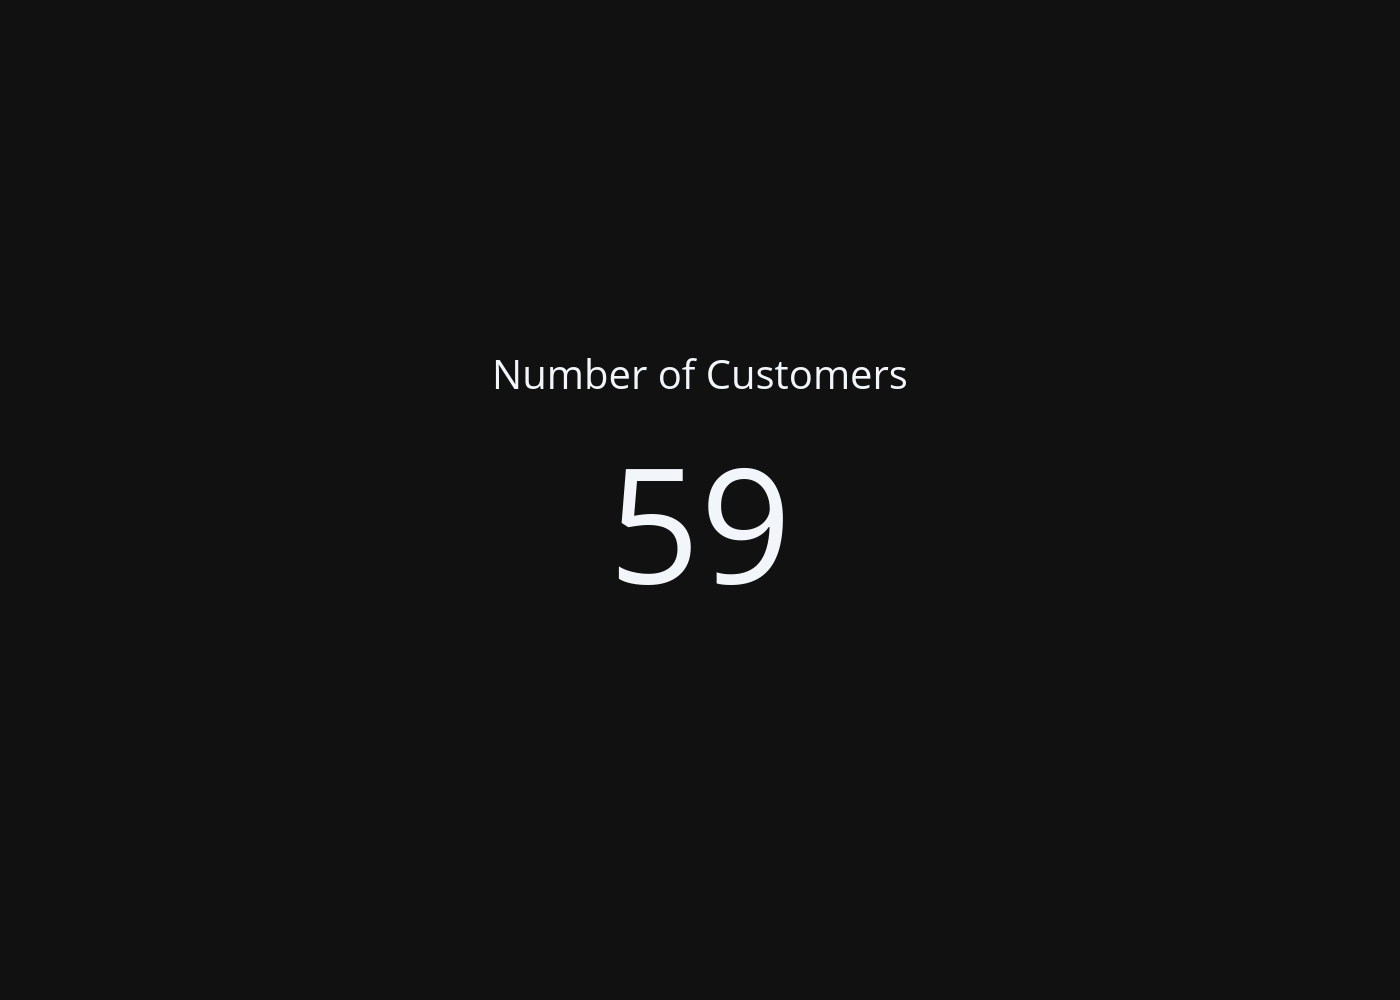

elapsed_time = 7.8115198612213135


In [17]:
ts_start = time()
question = "How many customers are there"
# resp = vn.ask_adaptive(question=question)
resp = vn.ask(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
raise Exception("Pause")

Exception: Pause

In [ ]:
### Loop over questions

In [ ]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

In [ ]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [ ]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

In [ ]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

### Save training data

In [ ]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

In [ ]:
df_training_data.to_csv(file_csv, index=False)